In [70]:
!pip install imbalanced-learn
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Initial Imports  

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay
)
from imblearn.over_sampling import SMOTE
import pandas_profiling as pp
from collections import Counter


<br>
<br>
<br>

<hr>

### Data Loading & Basic Checks
- Load dataset from CSV file  
- Print basic information:  
  * Column structure and data types  
  * First 5 rows  
  * Numerical feature statistics  

In [72]:
df = pd.read_csv('/content/sample_data/hepatitis.csv')
print("\nInitial DataFrame Info:")
df.info()
print("\nInitial DataFrame Head:")
print(df.head())
print("\nInitial Numerical Features Description:")
print(df.describe())


Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          155 non-null    int64 
 1   target      155 non-null    int64 
 2   age         155 non-null    int64 
 3   gender      155 non-null    int64 
 4   steroid     155 non-null    object
 5   antivirals  155 non-null    int64 
 6   fatigue     155 non-null    object
 7   malaise     155 non-null    object
 8   anorexia    155 non-null    object
 9   liverBig    155 non-null    object
 10  liverFirm   155 non-null    object
 11  spleen      155 non-null    object
 12  spiders     155 non-null    object
 13  ascites     155 non-null    object
 14  varices     155 non-null    object
 15  bili        155 non-null    object
 16  alk         155 non-null    object
 17  sgot        155 non-null    object
 18  albu        155 non-null    object
 19  protime     155 non-null 

<br>
<br>
<br>

<hr>

### Label Encoding  
- Binary conversion for:  
  * `target`
  * `gender`

In [73]:
if 'target' in df.columns:
    df['target'] = df['target'].replace({1: 0, 2: 1})
    print("\nTarget variable transformed (1->0, 2->1).")
if 'gender' in df.columns:
    df['gender'] = df['gender'].replace({1: 0, 2: 1})
    print("Gender variable transformed (1->0, 2->1).")


Target variable transformed (1->0, 2->1).
Gender variable transformed (1->0, 2->1).


<br>
<br>
<br>

<hr>

### Binary Features Processing  
- Standardizes binary columns   
- Handles:  
  * Missing values ('?'→NaN)  
  * Numeric conversion  
  * Both float (1.0/2.0) and int (1/2) formats  

In [74]:
binary_cols_from_schema = [
    'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia',
    'liverBig', 'liverFirm', 'spleen', 'spiders', 'ascites', 'varices', 'histology'
]
print("\nTransforming binary features (1.0->0, 2.0->1 or 1->0, 2->1)...")
for col in binary_cols_from_schema:
    if col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].replace({'?': np.nan})
        df[col] = pd.to_numeric(df[col], errors='coerce')
        if set(df[col].dropna().unique()).issubset({1.0, 2.0}):
             df[col] = df[col].replace({1.0: 0, 2.0: 1})
        elif set(df[col].dropna().unique()).issubset({1, 2}):
             df[col] = df[col].replace({1: 0, 2: 1})
print("Binary feature transformation attempt complete.")



Transforming binary features (1.0->0, 2.0->1 or 1->0, 2->1)...
Binary feature transformation attempt complete.


<br>
<br>
<br>

<hr>

### Missing Value Handling
- Checks initial missing values
- Drops rows with missing target
- Imputation strategy:
  * IterativeImputer for numerical features
  * Mode for categorical/binary features
  * Median as fallback
- Reports final missing value status

In [75]:
print("\nInitial missing values count:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

if missing_values.sum() > 0:
    print("\nStarting missing value imputation...")
    if 'target' in df.columns and df['target'].isnull().any():
         print("Missing values found in 'target' column. Rows with NaN target will be dropped.")
         df.dropna(subset=['target'], inplace=True)
         df.reset_index(drop=True, inplace=True)

    cols_to_impute_iterative = df.select_dtypes(include=np.number).columns.tolist()
    if 'target' in cols_to_impute_iterative:
        cols_to_impute_iterative.remove('target')

    if cols_to_impute_iterative:
        imputable_df_iterative = df[cols_to_impute_iterative]
        if not imputable_df_iterative.empty and imputable_df_iterative.isnull().any().any():
            print(f"Applying IterativeImputer to: {cols_to_impute_iterative}")
            imputer_iterative = IterativeImputer(max_iter=10, random_state=0, tol=1e-3)
            df_imputed_values = imputer_iterative.fit_transform(imputable_df_iterative)
            df_imputed_iterative = pd.DataFrame(df_imputed_values, columns=imputable_df_iterative.columns, index=df.index)
            for col in df_imputed_iterative.columns:
                df[col] = df_imputed_iterative[col]
            print("IterativeImputer applied to numerical columns.")
        else:
            print("No numerical columns require IterativeImputation or imputable part is empty.")

    missing_after_iterative = df.isnull().sum()
    cols_with_remaining_nans = missing_after_iterative[missing_after_iterative > 0].index.tolist()

    if cols_with_remaining_nans:
        print(f"Applying fallback imputation (mode/median) for: {cols_with_remaining_nans}")
        for col in cols_with_remaining_nans:
            if df[col].isnull().any():
                if col in binary_cols_from_schema or df[col].dropna().nunique() < 10:
                    mode_val = df[col].mode()
                    if not mode_val.empty:
                        df[col] = df[col].fillna(mode_val[0])
                    else:
                        if pd.api.types.is_numeric_dtype(df[col]):
                            df[col] = df[col].fillna(df[col].median())
                        else:
                            df[col] = df[col].fillna("Unknown")
                else:
                    df[col] = df[col].fillna(df[col].median())
        print("Fallback imputation complete.")

    print("\nFinal missing values count after imputation:")
    final_missing = df.isnull().sum()
    print(final_missing[final_missing > 0])
    if final_missing.sum() == 0:
        print("All missing values handled.")
else:
    print("\nNo missing data to impute.")



Initial missing values count:
steroid       1
fatigue       1
malaise       1
anorexia      1
liverBig     10
liverFirm    11
spleen        5
spiders       5
ascites       5
varices       5
dtype: int64

Starting missing value imputation...
Applying IterativeImputer to: ['ID', 'age', 'gender', 'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 'liverBig', 'liverFirm', 'spleen', 'spiders', 'ascites', 'varices', 'histology']
IterativeImputer applied to numerical columns.

Final missing values count after imputation:
Series([], dtype: int64)
All missing values handled.


<br>
<br>
<br>

<hr>

### Duplicate Handling & Final Check
- Checks for duplicate rows
- Removes if found (keeps first occurrence)
- Displays final dataframe info and sample`

In [76]:
duplicate_rows = df.duplicated().sum()
if duplicate_rows > 0:
    print(f"\nFound {duplicate_rows} duplicate rows. Removing them...")
    df.drop_duplicates(inplace=True, keep='first')
    df.reset_index(drop=True, inplace=True)
    print("Duplicate rows removed and index reset.")
else:
    print("\nNo duplicate rows found.")

print("\nDataFrame Info after Preprocessing:")
df.info()
print(df.head())


No duplicate rows found.

DataFrame Info after Preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          155 non-null    float64
 1   target      155 non-null    int64  
 2   age         155 non-null    float64
 3   gender      155 non-null    float64
 4   steroid     155 non-null    float64
 5   antivirals  155 non-null    float64
 6   fatigue     155 non-null    float64
 7   malaise     155 non-null    float64
 8   anorexia    155 non-null    float64
 9   liverBig    155 non-null    float64
 10  liverFirm   155 non-null    float64
 11  spleen      155 non-null    float64
 12  spiders     155 non-null    float64
 13  ascites     155 non-null    float64
 14  varices     155 non-null    float64
 15  bili        155 non-null    object 
 16  alk         155 non-null    object 
 17  sgot        155 non-null    object 
 18  albu   

<br>
<br>
<br>

<hr>

### EDA: Outlier Analysis
- Boxplots for numerical features (nunique > 5)
- Shows IQR range and outlier counts
- No treatment applied (diagnostic only)

 Exploratory Data Analysis (Optional Visualizations) 

Outlier Analysis (IQR for numerical features):
  Column 'ID': 0 outliers detected (IQR: [-76.00, 232.00])
  Column 'age': 1 outliers detected (IQR: [5.00, 77.00])
  Column 'liverBig': 35 outliers detected (IQR: [1.00, 1.00])
  Column 'liverFirm': 0 outliers detected (IQR: [-1.50, 2.50])
  Column 'spleen': 35 outliers detected (IQR: [1.00, 1.00])
  Column 'spiders': 0 outliers detected (IQR: [-1.50, 2.50])
  Column 'ascites': 25 outliers detected (IQR: [1.00, 1.00])
  Column 'varices': 23 outliers detected (IQR: [1.00, 1.00])


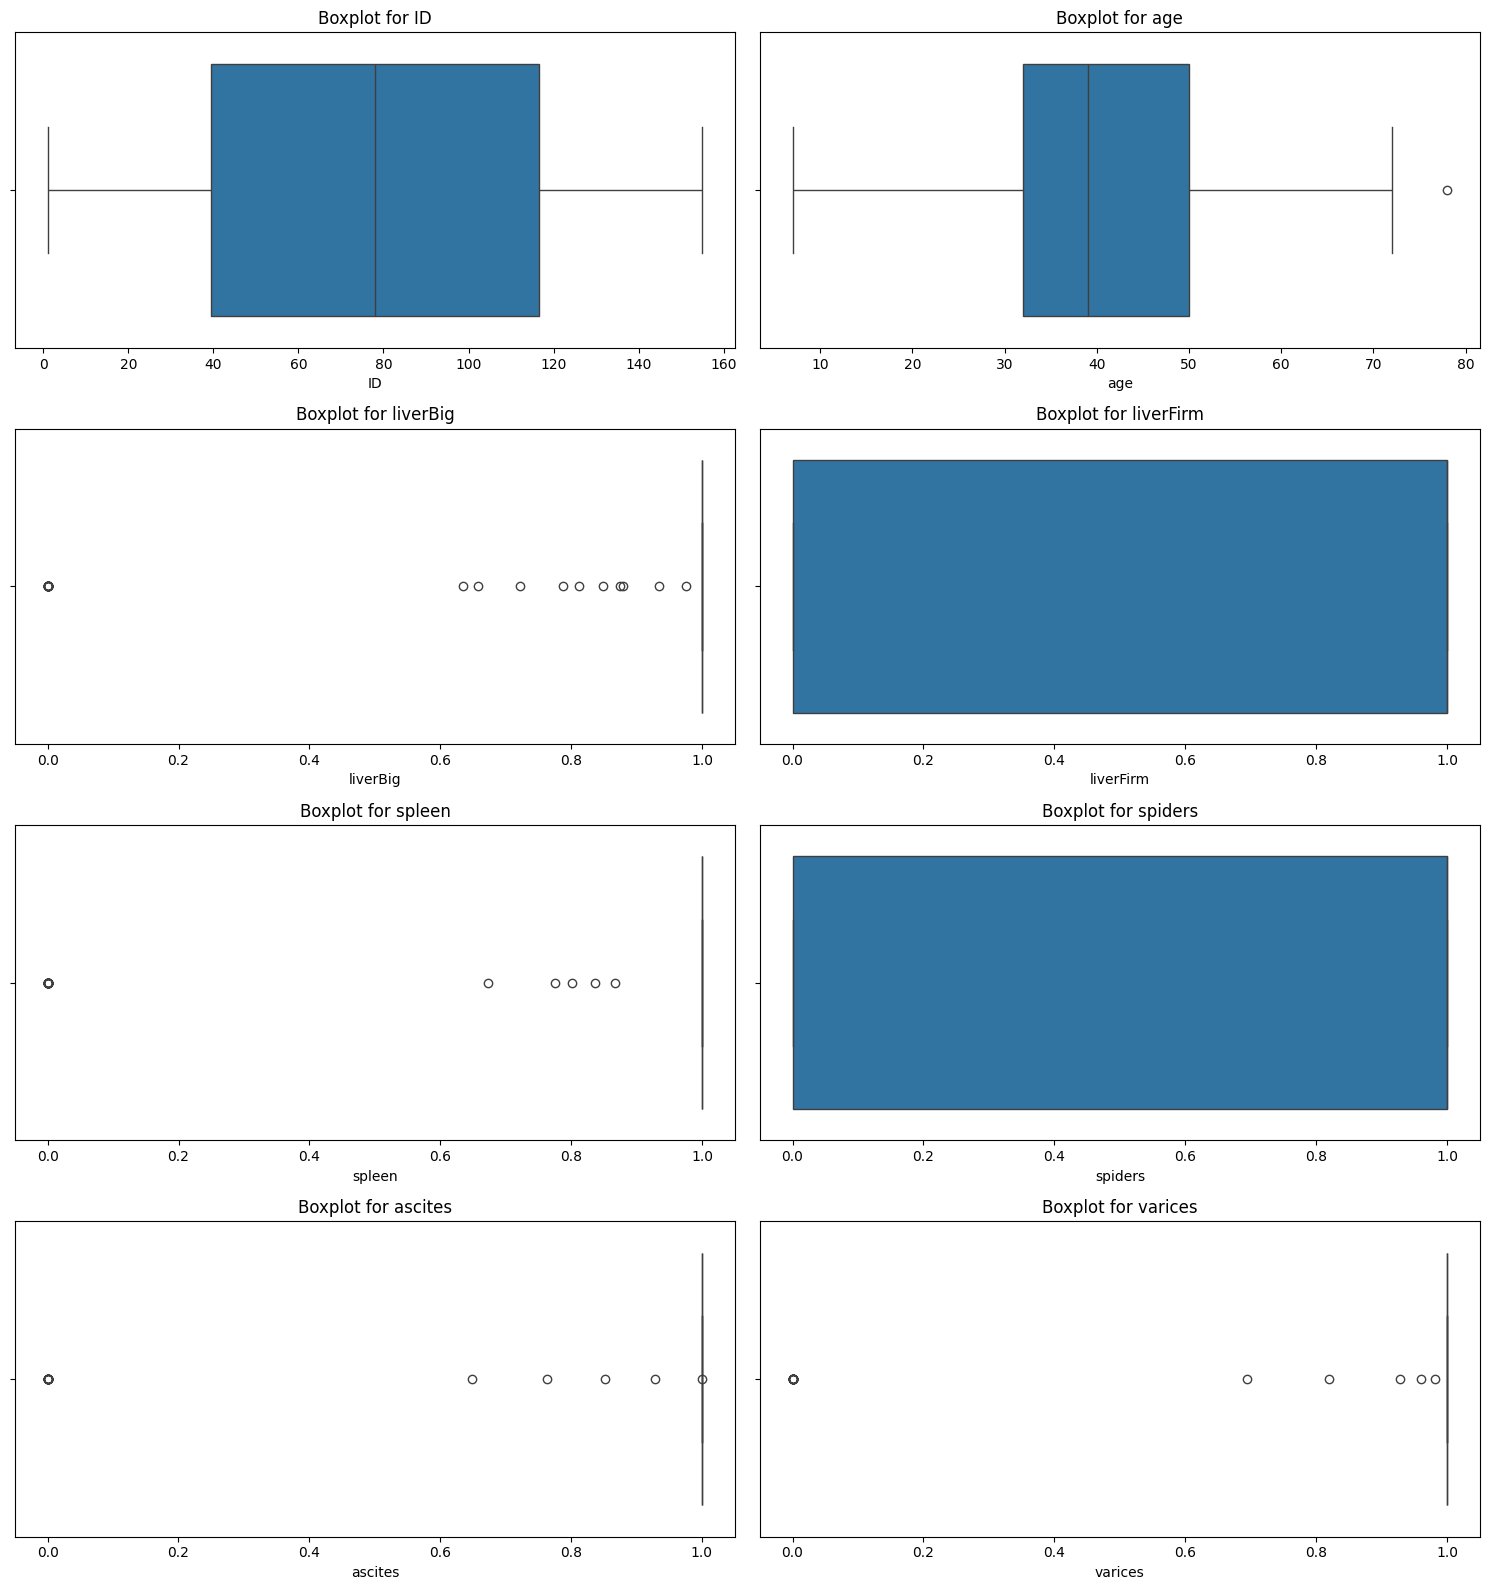

Note: Outliers are only identified here, not treated yet.


In [77]:
print(" Exploratory Data Analysis (Optional Visualizations) ")

numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
if 'target' in numerical_cols: numerical_cols.remove('target')
true_numerical_cols = [col for col in numerical_cols if df[col].dropna().nunique() > 5]
categorical_eda_cols = [col for col in df.columns if col not in true_numerical_cols and col != 'target']

print("\nOutlier Analysis (IQR for numerical features):")
if true_numerical_cols:
    plt.figure(figsize=(15, max(5, len(true_numerical_cols) * 2)))
    for i, col in enumerate(true_numerical_cols):
        plt.subplot( (len(true_numerical_cols) + 1) // 2, 2, i + 1)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot for {col}')
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        print(f"  Column '{col}': {len(outliers)} outliers detected (IQR: [{lower_bound:.2f}, {upper_bound:.2f}])")
    plt.tight_layout()
    plt.show()
else:
    print("No 'true' numerical columns identified for outlier boxplots.")
print("Note: Outliers are only identified here, not treated yet.")


### Target Analysis Visualizations
- Numerical features: Stacked histograms by target
- Categorical features: Normalized stacked bar charts
- Shows distribution patterns vs. target


Visualizing Feature Impact on Target:


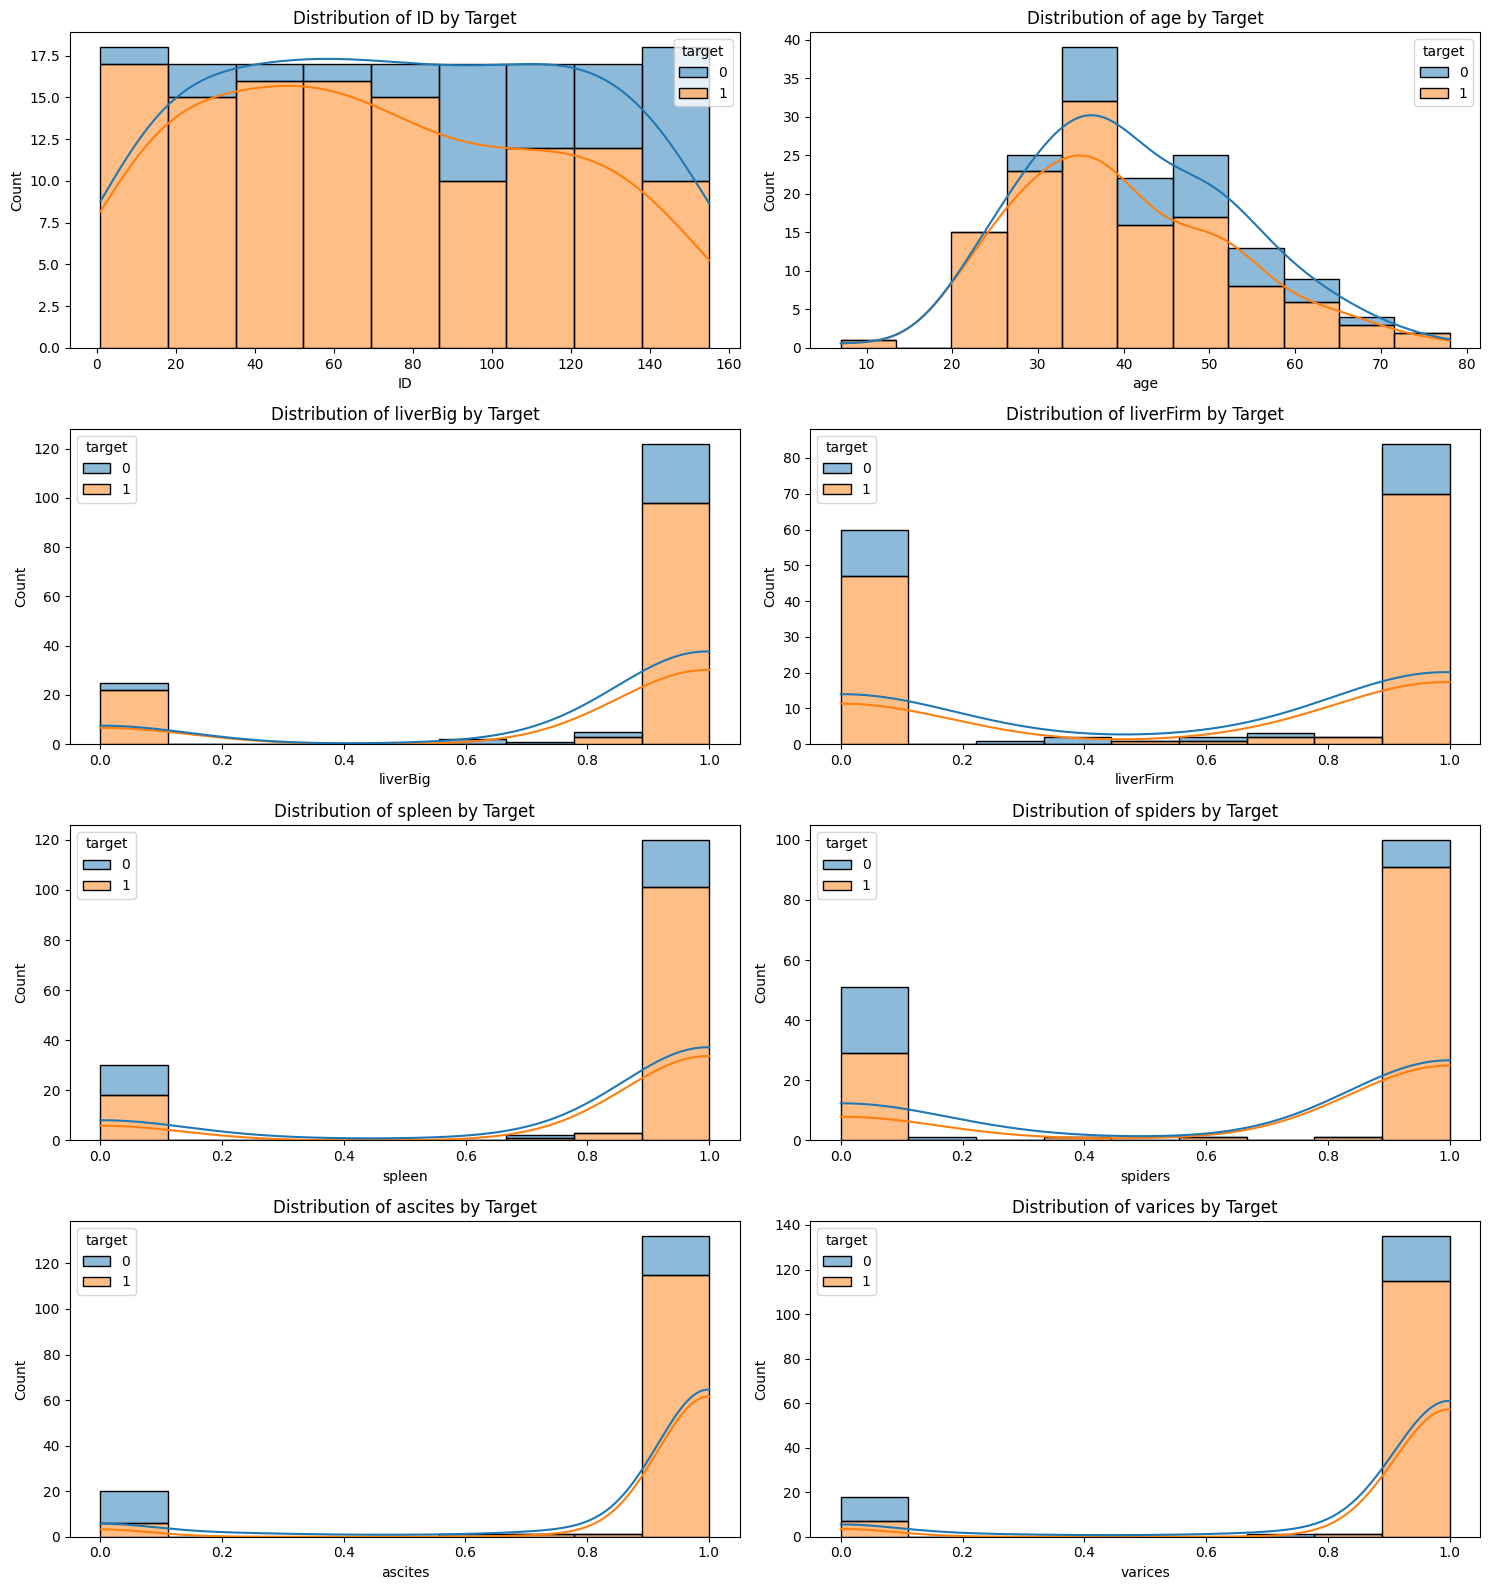

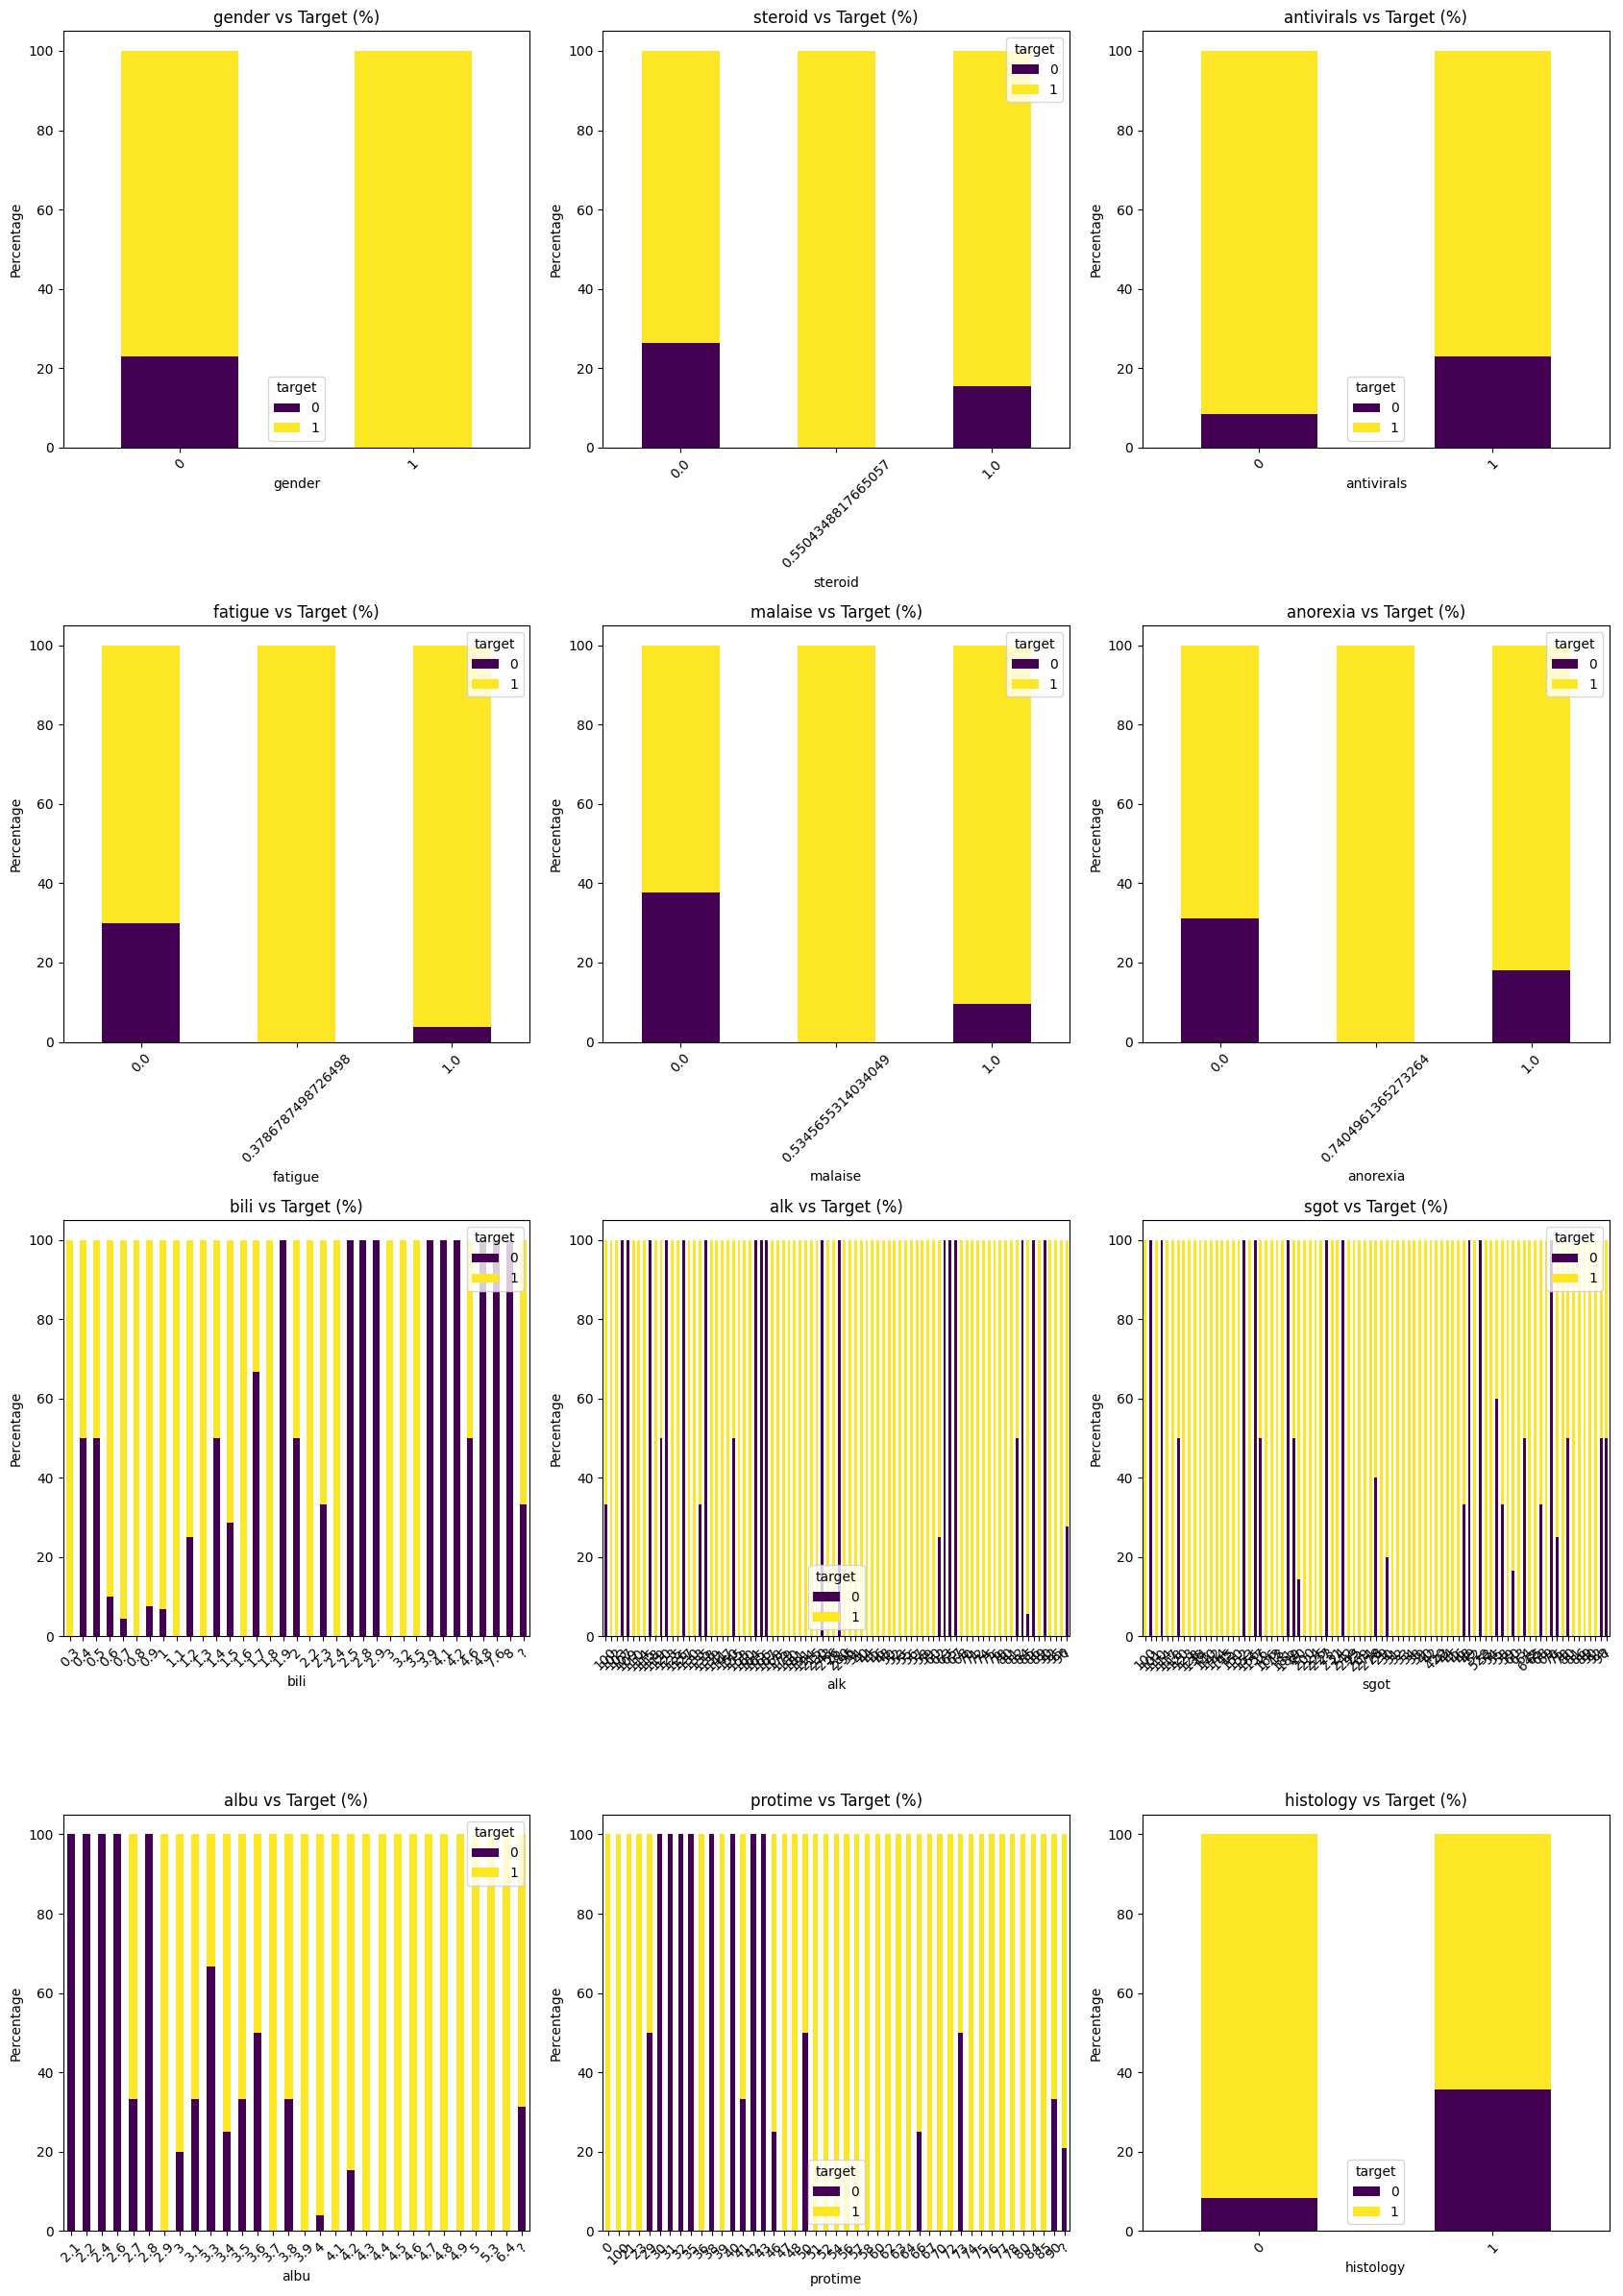

In [78]:

if 'target' in df.columns:
    print("\nVisualizing Feature Impact on Target:")
    if true_numerical_cols:
        plt.figure(figsize=(15, max(5, len(true_numerical_cols) * 2)))
        for i, col in enumerate(true_numerical_cols):
            plt.subplot((len(true_numerical_cols) + 1) // 2, 2, i + 1)
            sns.histplot(data=df, x=col, hue='target', kde=True, multiple="stack")
            plt.title(f'Distribution of {col} by Target')
        plt.tight_layout()
        plt.show()
    else:
        print("No 'true' numerical columns for target impact histograms.")

    if categorical_eda_cols:
        plt.figure(figsize=(17, max(5, len(categorical_eda_cols) * 2)))
        for i, col in enumerate(categorical_eda_cols):
            if col in df.columns:
                ax = plt.subplot((len(categorical_eda_cols) + 2) // 3, 3, i + 1)
                df_temp_crosstab = df.copy()
                if df_temp_crosstab['target'].dtype != 'int':
                    df_temp_crosstab['target'] = df_temp_crosstab['target'].astype(int)
                if df_temp_crosstab[col].dtype == 'float':
                    if (df_temp_crosstab[col].dropna() % 1 == 0).all():
                        df_temp_crosstab[col] = df_temp_crosstab[col].astype(int)

                crosstab_df_normalized = pd.crosstab(df_temp_crosstab[col], df_temp_crosstab['target'], normalize='index')*100
                crosstab_df_normalized.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')
                ax.set_title(f'{col} vs Target (%)')
                ax.set_ylabel('Percentage')
                ax.tick_params(axis='x', rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No categorical columns identified for target impact countplots/barplots.")
else:
    print("Target column not found. Skipping feature impact visualizations.")


### Feature Correlation Analysis
- Heatmap of numerical feature correlations
- Shows:
  * Pairwise correlations (Pearson)
  * Target correlation ranking


Feature Correlation Matrix (Numerical Features):


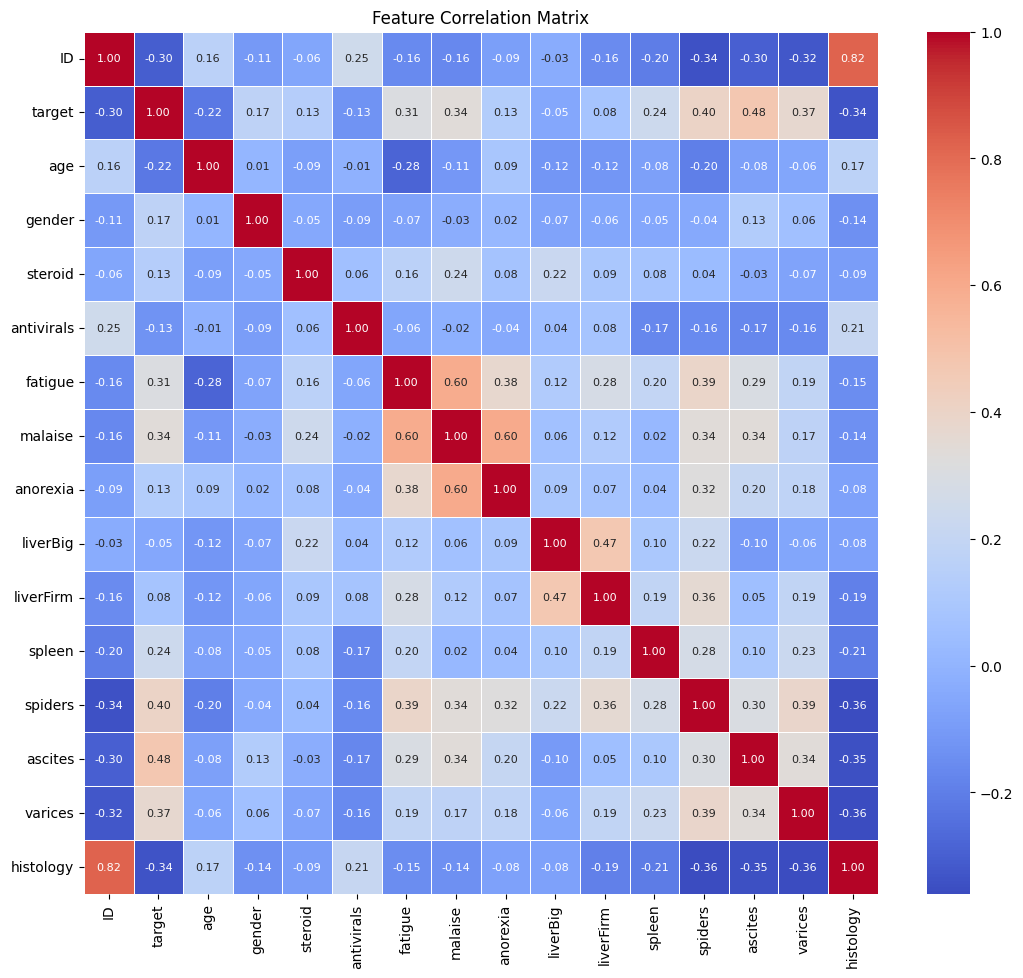


Correlation with Target:
ascites       0.478192
spiders       0.404211
varices       0.371424
malaise       0.337084
fatigue       0.309198
spleen        0.239570
gender        0.173051
steroid       0.134872
anorexia      0.131633
liverFirm     0.077860
liverBig     -0.053224
antivirals   -0.130196
age          -0.219647
ID           -0.302090
histology    -0.337856
Name: target, dtype: float64


In [79]:
print("\nFeature Correlation Matrix (Numerical Features):")
numerical_features_for_corr = df.select_dtypes(include=np.number)
if not numerical_features_for_corr.empty:
    correlation_matrix = numerical_features_for_corr.corr()
    plt.figure(figsize=(max(12, len(numerical_features_for_corr.columns)*0.8), max(10, len(numerical_features_for_corr.columns)*0.7)))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
    plt.title('Feature Correlation Matrix')
    plt.show()

    if 'target' in correlation_matrix.columns:
        print("\nCorrelation with Target:")
        print(correlation_matrix['target'].sort_values(ascending=False).drop('target'))
else:
    print("No numerical features found for correlation matrix.")


### Data Profiling Report
- Generates comprehensive HTML report using pandas-profiling
- Includes:
  * Feature statistics
  * Missing values analysis
  * Correlations
  * Data distributions
- Saves as 'profile_report.html'

In [80]:
def generate_profile_report(dataframe, output_file='profile_report.html'):
    if pp is None:
        print("Pandas Profiling library is not available. Cannot generate report.")
        return

    if dataframe is not None and not dataframe.empty:
        print(f"\nGenerating profile report for dataframe with {dataframe.shape[0]} rows and {dataframe.shape[1]} columns...")
        try:
            report = pp.ProfileReport(dataframe,
                                     title="Data Profiling Report",
                                     explorative=True,
                                     minimal=False)

            report.to_file(output_file)
            print(f"Profile report successfully saved to '{output_file}'.")
            print("This HTML file contains comprehensive analysis of features, correlations, missing values and more.")

        except Exception as e:
            print(f"Error while generating profile report: {e}")
            print("Please check if pandas-profiling (or ydata-profiling) is properly installed and the dataframe is valid.")

    else:
        print("Dataframe is empty or doesn't exist. Please provide a valid dataframe.")

if 'df' in locals() or 'df' in globals():
    generate_profile_report(df, 'profile_report.html')


Generating profile report for dataframe with 155 rows and 21 columns...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 21/21 [00:00<00:00, 77.03it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Profile report successfully saved to 'profile_report.html'.
This HTML file contains comprehensive analysis of features, correlations, missing values and more.


### Modeling Data Preparation
- Separates features (X) and target (y)
- Handles potential issues:
  * Checks for missing target
  * Converts object columns to numeric
  * Imputes new NaNs with median

In [81]:
if 'target' not in df.columns:
    print("Target column is missing. Cannot proceed with model building.")
if df['target'].isnull().any():
    print("Target column contains NaN values after preprocessing.")

X = df.drop(columns=['target'])
y = df['target'].astype(int)

object_cols_in_X = X.select_dtypes(include='object').columns
if len(object_cols_in_X) > 0:
    print(f"Warning: Object columns found in features X: {object_cols_in_X.tolist()}")
    print("Attempting to convert to numeric. Ensure this is intended and data is clean.")
    for col in object_cols_in_X:
        X[col] = pd.to_numeric(X[col], errors='coerce')
    if X.isnull().any().any():
        print("New NaNs created after trying to convert object columns. Applying median imputation.")
        for col in X.columns:
            if X[col].isnull().any():
                X[col] = X[col].fillna(X[col].median())


Attempting to convert to numeric. Ensure this is intended and data is clean.
New NaNs created after trying to convert object columns. Applying median imputation.


<br>
<br>

### Train-Test Split
- 70% training / 30% test
- Stratified by target
- Preserves class distribution

In [82]:
X_train_orig, X_test_orig, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
print(f"Original X_train shape: {X_train_orig.shape}, y_train shape: {y_train.shape}")
print(f"Original X_test shape: {X_test_orig.shape}, y_test shape: {y_test.shape}")
print(f"Class distribution in y_train: {Counter(y_train)}")
print(f"Class distribution in y_test: {Counter(y_test)}")

Original X_train shape: (108, 20), y_train shape: (108,)
Original X_test shape: (47, 20), y_test shape: (47,)
Class distribution in y_train: Counter({1: 86, 0: 22})
Class distribution in y_test: Counter({1: 37, 0: 10})


### Feature Scaling
- Standardizes features using StandardScaler
- Fits scaler on training data only
- Transforms both training and test sets
- Maintains original column names and indices

In [83]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_orig)
X_test_scaled = scaler.transform(X_test_orig)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_orig.columns, index=X_train_orig.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_orig.columns, index=X_test_orig.index)
print("Features scaled.")

Features scaled.


<br>
<br>

### Class Imbalance Handling
- Applies SMOTE oversampling
- Balances minority class in training data
- Only applied to training set (not test set)
- Preserves original test distribution

In [84]:
print(f"Class distribution in y_train BEFORE SMOTE: {Counter(y_train)}")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled_df, y_train)


Class distribution in y_train BEFORE SMOTE: Counter({1: 86, 0: 22})


In [85]:

if not isinstance(X_train_smote, pd.DataFrame):
    X_train_smote_df = pd.DataFrame(X_train_smote, columns=X_train_orig.columns)
else:
    X_train_smote_df = X_train_smote
if not isinstance(y_train_smote, pd.Series):
    y_train_smote_series = pd.Series(y_train_smote, name='target', index=X_train_smote_df.index if hasattr(X_train_smote_df,'index') else None)
else:
    y_train_smote_series = y_train_smote

print(f"X_train shape AFTER SMOTE: {X_train_smote_df.shape}")
print(f"Class distribution in y_train AFTER SMOTE: {Counter(y_train_smote_series)}")


X_train shape AFTER SMOTE: (172, 20)
Class distribution in y_train AFTER SMOTE: Counter({1: 86, 0: 86})


<br>
<br>
<br>
<hr>

### PCA Dimensionality Reduction
- Retains 95% variance
- Fits on training data only
- Transforms both train/test sets
- Prints:
  * Selected components count
  * Total explained variance
  * Resulting shapes

In [86]:
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_smote_df)
X_test_pca = pca.transform(X_test_scaled_df)

print(f"Number of principal components selected: {pca.n_components_}")
print(f"Explained variance by selected components: {np.sum(pca.explained_variance_ratio_):.4f}")
print(f"X_train_pca shape: {X_train_pca.shape}")
print(f"X_test_pca shape: {X_test_pca.shape}")

Number of principal components selected: 16
Explained variance by selected components: 0.9626
X_train_pca shape: (172, 16)
X_test_pca shape: (47, 16)


<br>
<br>
<br>
<hr>

### Model Evaluation (5-Fold CV)
- Evaluates 3 models:
  * Balanced Random Forest
  * Balanced SVM (with probabilities)
  * MLP (with early stopping)
- Uses stratified 5-fold CV
- Tracks metrics:
  * Accuracy
  * Weighted Precision/Recall/F1
  * ROC AUC
- Reports per-fold and average scores

In [87]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']

models_to_evaluate = {
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "SVM": SVC(random_state=42, probability=True, class_weight='balanced'),
    "MLP": MLPClassifier(random_state=42, max_iter=700, early_stopping=True, n_iter_no_change=15)
}


print(" Detailed 5-Fold Cross-Validation (on default models using PCA-transformed training data):")
all_cv_results_detailed = {}
for model_name, model_instance in models_to_evaluate.items():
    print(f"\n--- Cross-Validating: {model_name} ---")
    cv_scores_detailed = cross_validate(
        model_instance, X_train_pca, y_train_smote_series,
        cv=stratified_kfold, scoring=scoring_metrics, n_jobs=-1
    )
    all_cv_results_detailed[model_name] = cv_scores_detailed
    print(f"Results for {model_name}:")
    for i in range(stratified_kfold.get_n_splits()):
        print(f"  Fold {i+1}:")
        for metric in scoring_metrics:
            score_key = f'test_{metric}'
            print(f"    {metric}: {cv_scores_detailed[score_key][i]:.4f}")
    print("  Average Scores:")
    for metric in scoring_metrics:
        score_key = f'test_{metric}'
        print(f"    Average {metric}: {np.mean(cv_scores_detailed[score_key]):.4f} (+/- {np.std(cv_scores_detailed[score_key]):.4f})")


 Detailed 5-Fold Cross-Validation (on default models using PCA-transformed training data):

--- Cross-Validating: Random Forest ---
Results for Random Forest:
  Fold 1:
    accuracy: 0.8857
    precision_weighted: 0.8857
    recall_weighted: 0.8857
    f1_weighted: 0.8857
    roc_auc: 0.9657
  Fold 2:
    accuracy: 0.9143
    precision_weighted: 0.9155
    recall_weighted: 0.9143
    f1_weighted: 0.9141
    roc_auc: 0.9739
  Fold 3:
    accuracy: 0.9118
    precision_weighted: 0.9132
    recall_weighted: 0.9118
    f1_weighted: 0.9117
    roc_auc: 0.9723
  Fold 4:
    accuracy: 0.8824
    precision_weighted: 0.8877
    recall_weighted: 0.8824
    f1_weighted: 0.8819
    roc_auc: 0.9775
  Fold 5:
    accuracy: 0.8824
    precision_weighted: 0.8877
    recall_weighted: 0.8824
    f1_weighted: 0.8819
    roc_auc: 0.9827
  Average Scores:
    Average accuracy: 0.8953 (+/- 0.0146)
    Average precision_weighted: 0.8980 (+/- 0.0134)
    Average recall_weighted: 0.8953 (+/- 0.0146)
    Averag

### Model Performance Analysis

**Random Forest**
- Accuracy: 89.53% (±1.46%)
- ROC AUC: 0.974 (±0.006)
- Most stable performance (lowest std dev)
- Consistent across all metrics

**SVM**
- Highest accuracy: 91.26% (±2.67%)
- ROC AUC: 0.972 (±0.016)
- Achieved perfect ROC (1.0) in one fold
- Slightly higher variance than RF

**MLP**
- Lowest accuracy: 79.11% (±9.61%)
- ROC AUC: 0.895 (±0.054)
- High variability between folds
- Underperformed on all metrics

**Key Findings**
- Tree-based (RF) and kernel-based (SVM) methods outperformed neural network
- All models show good discrimination (ROC AUC >0.89)
- SVM has highest peak performance
- RF shows most consistent results

<br>
<br>
<br>
<hr>

### Model Evaluation Function
- Calculates metrics for both train and test sets:
  * Accuracy, Precision, Recall, F1
  * ROC AUC (when available)
  * Confusion matrix
- Handles models with/without probability estimates
- Outputs:
  * Formatted performance metrics
  * Visualized confusion matrix
  * Classification report
- Stores models and predictions in global dicts

In [88]:
all_final_model_performances = {}
all_trained_best_models = {}

def evaluate_on_train_and_test(model_name_suffix, model, X_train_data, y_train_data, X_test_data, y_test_data, trained_models_dict_global):
    performance = {}
    y_train_pred = model.predict(X_train_data)
    y_train_proba = model.predict_proba(X_train_data)[:, 1] if hasattr(model, "predict_proba") else None

    performance['train_accuracy'] = accuracy_score(y_train_data, y_train_pred)
    performance['train_precision'] = precision_score(y_train_data, y_train_pred, average='weighted', zero_division=0)
    performance['train_recall'] = recall_score(y_train_data, y_train_pred, average='weighted', zero_division=0)
    performance['train_f1'] = f1_score(y_train_data, y_train_pred, average='weighted', zero_division=0)
    performance['train_roc_auc'] = roc_auc_score(y_train_data, y_train_proba) if y_train_proba is not None else None

    print(f"\n--- Evaluation for: {model_name_suffix} (ON TRAINING DATA) ---")
    print(f"  Accuracy: {performance['train_accuracy']:.4f}")
    if performance['train_roc_auc'] is not None:
        print(f"  ROC AUC: {performance['train_roc_auc']:.4f}")
    else:
        print(f"  ROC AUC: Not available")

    y_test_pred = model.predict(X_test_data)
    y_test_proba = None
    roc_auc_test = None

    if hasattr(model, "predict_proba"):
        y_test_proba = model.predict_proba(X_test_data)[:, 1]
        if y_test_proba is not None:
            roc_auc_test = roc_auc_score(y_test_data, y_test_proba)
    elif hasattr(model, "decision_function"):
        y_decision = model.decision_function(X_test_data)
        if y_decision.ndim > 1 and y_decision.shape[1] > 1 :
             y_decision = y_decision[:,1]
        roc_auc_test = roc_auc_score(y_test_data, y_decision)
        y_test_proba = y_decision

    trained_models_dict_global[model_name_suffix] = (model, y_test_proba)

    performance['test_accuracy'] = accuracy_score(y_test_data, y_test_pred)
    performance['test_precision'] = precision_score(y_test_data, y_test_pred, average='weighted', zero_division=0)
    performance['test_recall'] = recall_score(y_test_data, y_test_pred, average='weighted', zero_division=0)
    performance['test_f1'] = f1_score(y_test_data, y_test_pred, average='weighted', zero_division=0)
    performance['test_roc_auc'] = roc_auc_test
    performance['test_confusion_matrix'] = confusion_matrix(y_test_data, y_test_pred)

    print(f"\n--- Evaluation for: {model_name_suffix} (ON TEST DATA) ---")
    print(f"  Accuracy: {performance['test_accuracy']:.4f}")
    print(f"  Precision (Weighted): {performance['test_precision']:.4f}")
    print(f"  Recall (Weighted): {performance['test_recall']:.4f}")
    print(f"  F1 Score (Weighted): {performance['test_f1']:.4f}")
    if performance['test_roc_auc'] is not None:
        print(f"  ROC AUC: {performance['test_roc_auc']:.4f}")
    else:
        print("  ROC AUC: Not available")

    print("  Confusion Matrix (Test Data):")
    print(performance['test_confusion_matrix'])
    plt.figure(figsize=(6,4))
    sns.heatmap(performance['test_confusion_matrix'], annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Predicted 0 (Die)', 'Predicted 1 (Live)'],
                yticklabels=['Actual 0 (Die)', 'Actual 1 (Live)'])
    plt.title(f'Confusion Matrix - {model_name_suffix} (Test Data)')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

    print("  Classification Report (Test Data):")
    print(classification_report(y_test_data, y_test_pred, zero_division=0, target_names=['Class 0 (Die)', 'Class 1 (Live)']))
    return performance

<br>
<br>
<br>
<hr>

### Hyperparameter Tuning (GridSearchCV)
- **Random Forest**:
  - Searched: n_estimators, max_depth, min_samples_split/leaf, class_weight
  - Optimized for ROC AUC
  - Best CV score reported

- **SVM**:
  - Kernel: RBF & Poly
  - Tuned: C, gamma, degree, class_weight
  - Probability estimates enabled

- **MLP**:
  - Architecture search: hidden layers
  - Tuned: activation, alpha, learning rate
  - Early stopping enabled
  - Scaled to PCA dimensions

- All models:
  - 5-fold stratified CV
  - Best params and scores logged
  - Final evaluation on test set


--- Tuning MLP ---
Best MLP Parameters: {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (100, 50, 25), 'learning_rate_init': 0.005, 'max_iter': 700, 'n_iter_no_change': 20, 'solver': 'adam'}
Best MLP ROC AUC (CV): 0.9340

--- Evaluation for: MLP (Best Tuned) (ON TRAINING DATA) ---
  Accuracy: 0.9709
  ROC AUC: 0.9973

--- Evaluation for: MLP (Best Tuned) (ON TEST DATA) ---
  Accuracy: 0.8511
  Precision (Weighted): 0.8719
  Recall (Weighted): 0.8511
  F1 Score (Weighted): 0.8576
  ROC AUC: 0.9351
  Confusion Matrix (Test Data):
[[ 8  2]
 [ 5 32]]


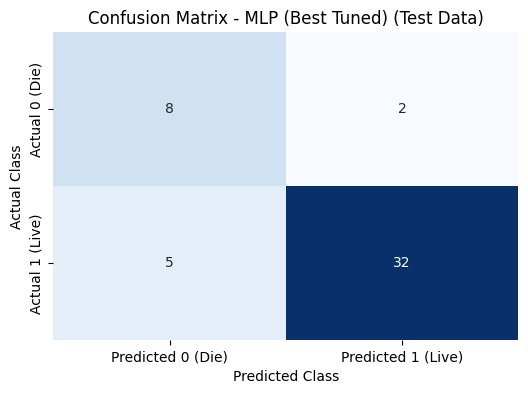

  Classification Report (Test Data):
                precision    recall  f1-score   support

 Class 0 (Die)       0.62      0.80      0.70        10
Class 1 (Live)       0.94      0.86      0.90        37

      accuracy                           0.85        47
     macro avg       0.78      0.83      0.80        47
  weighted avg       0.87      0.85      0.86        47



In [89]:
print("\n--- Tuning MLP ---")
n_pca_components = X_train_pca.shape[1]
param_grid_mlp = {
    'hidden_layer_sizes': [(n_pca_components,), (int(n_pca_components*0.75), int(n_pca_components*0.5)), (50, 25), (100,50,25)],
    'activation': ['relu', 'tanh'], 'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.005], 'learning_rate_init': [0.001, 0.005],
    'max_iter': [700, 1000], 'early_stopping': [True], 'n_iter_no_change': [15, 20]
}
grid_mlp = GridSearchCV(MLPClassifier(random_state=42),
                        param_grid_mlp, cv=stratified_kfold, scoring='roc_auc', n_jobs=-1, verbose=0)
grid_mlp.fit(X_train_pca, y_train_smote_series)
best_mlp = grid_mlp.best_estimator_
print(f"Best MLP Parameters: {grid_mlp.best_params_}")
print(f"Best MLP ROC AUC (CV): {grid_mlp.best_score_:.4f}")
all_final_model_performances["MLP (Best Tuned)"] = evaluate_on_train_and_test(
    "MLP (Best Tuned)", best_mlp, X_train_pca, y_train_smote_series, X_test_pca, y_test, all_trained_best_models
)


<br>
<br>

<br>
<hr>

### Final Model Performance Report




---  Comprehensive Model Performance Report ---

 Summary of Detailed 5-Fold Cross-Validation (Default Models on PCA Training Data):

  Model: Random Forest
    Average accuracy: 0.8953 (+/- 0.0146)
    Average precision_weighted: 0.8980 (+/- 0.0134)
    Average recall_weighted: 0.8953 (+/- 0.0146)
    Average f1_weighted: 0.8951 (+/- 0.0146)
    Average roc_auc: 0.9744 (+/- 0.0056)

  Model: SVM
    Average accuracy: 0.9126 (+/- 0.0267)
    Average precision_weighted: 0.9164 (+/- 0.0282)
    Average recall_weighted: 0.9126 (+/- 0.0267)
    Average f1_weighted: 0.9124 (+/- 0.0267)
    Average roc_auc: 0.9716 (+/- 0.0159)

  Model: MLP
    Average accuracy: 0.7911 (+/- 0.0961)
    Average precision_weighted: 0.8051 (+/- 0.0819)
    Average recall_weighted: 0.7911 (+/- 0.0961)
    Average f1_weighted: 0.7861 (+/- 0.1037)
    Average roc_auc: 0.8951 (+/- 0.0541)

 Summary of Tuned Model Performance (Train vs. Test):
              Model Train Accuracy Test Accuracy Train ROC AUC Test ROC

/tmp/ipython-input-3766061301.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary_df[float_cols] = summary_df[float_cols].applymap(lambda x: f"{x:.4f}" if pd.notnull(x) else "N/A")


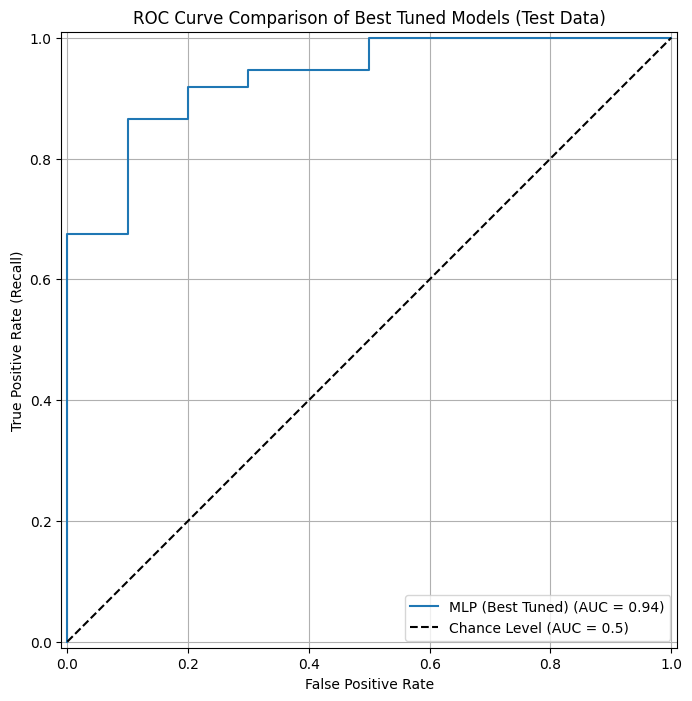


Skipping Pandas Profiling report generation (GENERATE_PROFILE_REPORT is False).


--- Machine Learning Pipeline Execution Complete ---


In [90]:
print("\n\n---  Comprehensive Model Performance Report ---")
print("\n Summary of Detailed 5-Fold Cross-Validation (Default Models on PCA Training Data):")
for model_name, cv_results in all_cv_results_detailed.items():
    print(f"\n  Model: {model_name}")
    for metric in scoring_metrics:
        score_key = f'test_{metric}'
        mean_score = np.mean(cv_results[score_key])
        std_score = np.std(cv_results[score_key])
        print(f"    Average {metric}: {mean_score:.4f} (+/- {std_score:.4f})")

print("\n Summary of Tuned Model Performance (Train vs. Test):")
summary_list = []
for model_name_key, perfs in all_final_model_performances.items():
    summary_list.append({
        'Model': model_name_key,
        'Train Accuracy': perfs.get('train_accuracy'),
        'Test Accuracy': perfs.get('test_accuracy'),
        'Train ROC AUC': perfs.get('train_roc_auc'),
        'Test ROC AUC': perfs.get('test_roc_auc'),
        'Test Precision': perfs.get('test_precision'),
        'Test Recall': perfs.get('test_recall'),
        'Test F1': perfs.get('test_f1'),
    })
summary_df = pd.DataFrame(summary_list)
float_cols = summary_df.select_dtypes(include='float').columns
summary_df[float_cols] = summary_df[float_cols].applymap(lambda x: f"{x:.4f}" if pd.notnull(x) else "N/A")
print(summary_df.to_string())

print("\n\n Plotting ROC Curve Comparison for Best Tuned Models (on Test Data)...")
if all_trained_best_models:
    plt.figure(figsize=(10, 8))
    for model_name, (model_obj, y_scores_for_roc) in all_trained_best_models.items():
        if y_scores_for_roc is not None:
            if isinstance(y_scores_for_roc, np.ndarray) and y_scores_for_roc.ndim > 1 and y_scores_for_roc.shape[1] > 1:
                 scores_to_plot = y_scores_for_roc[:, 1]
            else:
                 scores_to_plot = y_scores_for_roc
            RocCurveDisplay.from_predictions(y_test, scores_to_plot, name=model_name, ax=plt.gca())
        else:
            print(f"No ROC scores available for {model_name} to plot.")
    plt.plot([0, 1], [0, 1], 'k--', label='Chance Level (AUC = 0.5)')
    plt.title('ROC Curve Comparison of Best Tuned Models (Test Data)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No trained models with scores found for ROC curve plotting.")

GENERATE_PROFILE_REPORT = False # Set to True to generate the report
if GENERATE_PROFILE_REPORT:
    print("\n\n--- Generating Pandas Profiling Report (on the preprocessed DataFrame 'df') ---")
    if 'df' in locals() and not df.empty:
        profile = pp.ProfileReport(df, title="Pandas Profiling Report (After Preprocessing)", explorative=True)
        profile.to_file("profile_report_after_preprocessing.html")
        print("Profile report saved to 'profile_report_after_preprocessing.html'")
    else:
        print("DataFrame 'df' not available for profiling.")
else:
    print("\nSkipping Pandas Profiling report generation (GENERATE_PROFILE_REPORT is False).")

print("\n\n--- Machine Learning Pipeline Execution Complete ---")
